In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)

In [ ]:
from huggingface_hub import login
# TODO: replace below with your login code.
login()

In [ ]:
# TODO: change this path to your code location (the huggingface's code)
%cd /content/notebooks/packages/search-and-learn/

/content/drive/My Drive/Colab Notebooks/packages/search-and-learn


In [ ]:
!pip install -e '.[dev]'
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
# torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.4.0 which is incompatible.

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/packages/search-and-learn
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 93.7 MB/s 

In [ ]:
!python --version

Python 3.11.11


In [ ]:
!pip install vllm

In [ ]:
!python scripts/test_time_compute.py ./recipes/Llama-3.2-1B-Instruct/best_of_n.yaml

# with T4, I am getting the following error; L4 works fine.
#❯ ValueError: Bfloat16 is only supported on GPUs with compute capability of at least 8.0. Your Tesla T4 GPU has compute capability 7.5. You can use float16 instead by explicitly setting the`dtype` flag in CLI, for example: --dtype=half.

2025-02-12 20:18:01.103415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739391481.125819    3919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739391481.132605    3919 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION
config.json: 100% 877/877 [00:00<00:00, 4.72MB/s]
WARNING 02-12 20:18:22 arg_utils.py:953] Chunked prefill is enabled by default for models with max_model_len > 32K. Currently, chunked prefill might not work with some features or models. If yo

In [ ]:
import torch
import gc; gc.collect();torch.cuda.empty_cache();


In [ ]:
import copy
from tqdm import tqdm
from dataclasses import dataclass

import torch
from vllm import LLM, SamplingParams
from sal.models.reward_models import RLHFFlow

from sal.search.utils import Beam, build_conv, generate_k_steps, last
from sal.config import Config
from sal.models.reward_models import PRM
from sal.utils.score import aggregate_scores

base_path = "/content/drive/MyDrive/Colab Notebooks/packages/search-and-learn/"
model_path = base_path + "resources/Llama-3.2-1B-Instruct"     # "meta-llama/Llama-3.2-1B-Instruct"
prm_path = base_path + "resources/RLHFFlow/Llama3.1-8B-PRM-Deepseek-Data"

# import gc; gc.collect();torch.cuda.empty_cache();

# print('#--- memory:', torch.cuda.memory_allocated(0)/(1024**3))




/usr/local/lib/python3.11/dist-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


In [ ]:
llm = LLM(
    model=model_path,
    gpu_memory_utilization=0.5,  # Utilize 50% of GPU memory
    enable_prefix_caching=True,  # Optimize repeated prefix computations
    seed=42,  # Set seed for reproducibility
)


WARNING 02-26 22:32:37 arg_utils.py:953] Chunked prefill is enabled by default for models with max_model_len > 32K. Currently, chunked prefill might not work with some features or models. If you encounter any issues, please disable chunked prefill by setting --enable-chunked-prefill=False.
INFO 02-26 22:32:37 config.py:1005] Chunked prefill is enabled with max_num_batched_tokens=512.
INFO 02-26 22:32:37 llm_engine.py:237] Initializing an LLM engine (vdev) with config: model='/content/drive/MyDrive/Colab Notebooks/packages/search-and-learn/resources/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='/content/drive/MyDrive/Colab Notebooks/packages/search-and-learn/resources/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_si

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-26 22:32:42 model_runner.py:1071] Loading model weights took 2.3185 GB
INFO 02-26 22:32:42 gpu_executor.py:122] # GPU blocks: 33062, # CPU blocks: 8192
INFO 02-26 22:32:42 gpu_executor.py:126] Maximum concurrency for 131072 tokens per request: 4.04x
INFO 02-26 22:32:44 model_runner.py:1402] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 02-26 22:32:44 model_runner.py:1406] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 02-26 22:33:07 model_runner.py:1530] Graph capturing finished in 23 secs.


In [ ]:
prm = RLHFFlow(prm_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import ipdb

In [ ]:
question_text = "Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$"
input_batch = {"problem": [question_text]}

In [ ]:
import numpy as np
from sal.search.utils import Beam, build_conv, generate_k_steps, last


In [ ]:
config = Config()
config.agg_strategy = 'last'
config.n = 2
config.lookahead = 2
config.num_iterations = 10

@dataclass
class GenResult:
    index: int
    initial_prompt: str
    first_step_text: str
    first_step_stop_reason: str
    lookahead_text: str
    stop_reason: str | None

def generate_k_steps(
    templated_convs,
    lookahead_steps: int,
    llm: LLM,
    sampling_params: SamplingParams,
    beam_width: int,
) -> list[Beam]:
    '''

    '''

    gen_results = []
    for i, text in enumerate(templated_convs):
        for j in range(beam_width):
            gen_result = GenResult(
                index=i,
                initial_prompt=text,
                first_step_text="",
                lookahead_text="",
                stop_reason=None,
                first_step_stop_reason=None,
            )
            gen_results.append(gen_result)


    gen_sampling_params = copy.deepcopy(sampling_params)

    for i in range(lookahead_steps + 1):
        if i == 1:
            gen_sampling_params.temperature = 0.0  # greedy for the rest of the steps
        # get all generations that did not finish with eos
        # print(gen_results)
        current_gen = [
            gen_results[i]
            for i in range(len(gen_results))
            if gen_results[i].stop_reason != "EOS"
        ]
        gen_prompts = [
            gen_result.initial_prompt + gen_result.lookahead_text
            for gen_result in current_gen
        ]


        llm_outputs = llm.generate(gen_prompts, gen_sampling_params, use_tqdm=False)
        for gen_result, output in zip(current_gen, llm_outputs):
            gen_text = output.outputs[0].text
            # print(gen_text)
            # stop
            if i == 0:
                gen_result.first_step_text = gen_text
                gen_result.first_step_stop_reason = output.outputs[0].stop_reason
                if gen_result.first_step_stop_reason is None:
                    gen_result.first_step_stop_reason = "EOS"

            gen_result.lookahead_text = gen_result.lookahead_text + gen_text
            gen_result.stop_reason = output.outputs[0].stop_reason
            if gen_result.stop_reason is None:
                gen_result.stop_reason = "EOS"

    outputs: list[Beam] = []

    counter = 0
    for i, text in enumerate(templated_convs):
        next_texts = []
        stop_reasons = []
        lookahead_texts = []
        for j in range(beam_width):
            gen_result = gen_results[counter]
            next_texts.append(gen_result.first_step_text)
            lookahead_texts.append(gen_result.lookahead_text)
            stop_reasons.append(gen_result.first_step_stop_reason)
            counter += 1

        beam_result = Beam(
            prompt=text,
            index=i,
            current_text="",
            next_texts=next_texts,
            lookahead_texts=lookahead_texts,
            stop_reasons=stop_reasons,
            best_scores=[0.0],
            all_scores=[],
            previous_text=None,
            pruned=False,
            history=[],
        )
        outputs.append(beam_result)

    return outputs

def _beam_search(batch_of_prompts, config: Config, llm: LLM, prm: PRM) -> list[Beam]:
    '''
    _beam_search: private function, the core beam search algorithm
    - batch_of_prompts:
        a list of input prompts ["What is the capital of USA", "What is the length of the Nile River?"]
        config: a Config object with settings
    '''

    sampling_params = SamplingParams(temperature=config.temperature,
                                    max_tokens=config.max_tokens,
                                    top_p=config.top_p,
                                    stop=["\n\n"],
                                    include_stop_str_in_output=True,
                                    n=1)

    # ipdb.set_trace()
    beams: list[Beam] = []
    # create config.n beams for each prompt in the batch.
    for prompt in batch_of_prompts:
        for i in range(config.n):
            beams.append(
                Beam(
                    prompt=prompt,
                    index=i,
                    current_text="",
                    next_texts=None,
                    lookahead_texts=None,
                    pruned=False,           # flag to track whether beam is active
                    completed=False,        # flag to track completion
                    stop_reasons=None,
                    history=[],             # list of generated text segments
                    best_scores=[],
                    all_scores=[],
                    previous_text=None,
                    completion_tokens=0,    # token counts
                )
            )

    completed_beams: list[Beam] = []

    for i in range(config.num_iterations):
        print(f"\n-> i = {i}")
        # filters beams to get only active (non-pruned) ones
        # first iteration i==0: uses all intial beams
        if i == 0:
            active_beams = [b for b in beams if not b.pruned]
        else:
            active_beams = [b for b in active_beams if not b.pruned]

        # duplicate active beams to ensure that we have config.n beams per iteration
        # when do we have to duplicate active beams?
        if len(active_beams) != config.n:
            repeats = (config.n // len(active_beams)) + 1
            # logger.debug(
            #     f"Extending active_beams with {repeats} repetitions to reach size {config.n}"
            # )
            extended_active_beams = [
                copy.deepcopy(b) for b in (active_beams * repeats)[: config.n]
            ]
            active_beams = extended_active_beams
            if len(active_beams) != config.n:
                raise ValueError(
                    f"Expected {config.n} active beams, but got {len(active_beams)}"
                )

        # adjust sampling_params for the last iterations
        # one difference from the general sampling_params
        # remove the parameter stop strings
        if i == config.num_iterations - 1:
            # Last iteration, generate to EOS
            sampling_params = SamplingParams(
                temperature=config.temperature,
                max_tokens=config.max_tokens,
                top_p=config.top_p,
                n=1,
            )

        # builds conversation contexts for each active beam
        convs = [
            build_conv(b.prompt, b.current_text, config.system_prompt)
            for b in active_beams
        ]

        # set flags for conversation formatting
        continue_final_message = i > 0      # True after the first iteration to append to existing text.
        add_generation_prompt = i == 0      # True only on the first iteration to start generation.

        # override the default chat template if a custom one is provided.
        tokenizer = llm.get_tokenizer()
        if config.custom_chat_template is not None:
            tokenizer.chat_template = config.custom_chat_template

        # ipdb.set_trace()
        templated_convs = tokenizer.apply_chat_template(
            convs,
            add_generation_prompt=add_generation_prompt,
            continue_final_message=continue_final_message,
            tokenize=False          # return strings, not token IDs, e.g.,
                                    # [[128006, 9125, 128007, 271, 38766]?
        )
        print(templated_convs)
        stop

        # set number of lookahead steps, 0 (no lookahead) on the last iteration
        lookahead = 0 if i == config.num_iterations - 1 else config.lookahead

        #
        gen_results = generate_k_steps(
            templated_convs, lookahead, llm, sampling_params, 1
        )

        prompts, completions = [], []

        # print("beams")
        for beam, gen_result in zip(active_beams, gen_results, strict=True):
            # print(beam)
            # print(gen_result)
            beam.next_texts = gen_result.next_texts
            beam.stop_reasons = gen_result.stop_reasons
            beam.lookahead_texts = gen_result.lookahead_texts
            beam.completion_tokens += gen_result.completion_tokens
            beam.current_text += beam.next_texts[0]
            beam.history.append(beam.next_texts[0])
            # print()
            # print("beam.next_texts")
            # print(gen_result.next_texts)
            # print("beam.stop_reasons")
            # print(gen_result.stop_reasons)
            # print("beam.lookahead_texts")
            # print(gen_result.lookahead_texts)
            # print("beam.current_text")
            # print(beam.next_texts[0])
            # print(beam.current_text)
            # print("beam.completion_tokens")
            # print(gen_result.completion_tokens)
            # print(beam.completion_tokens)

            if (
                beam.stop_reasons[0] == "EOS"
                or beam.stop_reasons[0] == "length"
                or beam.next_texts[0] == ""
            ):
                beam.completed = True
                completed_beams.append(beam)
            prompts.append(beam.prompt)
            completions.append([beam.current_text])

        # print(prompts)
        # print()
        # print("completions")
        # print(completions)

        scores = prm.score(prompts, completions)
        agg_scores = [
            [aggregate_scores(s, config.agg_strategy) for s in score]
            for score in scores
        ]
        # print("scores")
        # print(scores)
        # print(agg_scores)

        for beam, score in zip(active_beams, scores, strict=True):
            beam.all_scores = score[0]

        # filter active_beams and agg_scores for beams that are completed
        agg_scores = [
            agg_scores[i] for i, b in enumerate(active_beams) if not b.completed
        ]
        active_beams = [b for b in active_beams if not b.completed]

        # early stopping if all beams are completed
        if len(active_beams) == 0:
            break

        # filter duplicate active beams
        if config.filter_duplicates:
            # Create a dictionary to filter duplicates and retain order
            unique_beam_dict = {}
            for i, b in enumerate(active_beams):
                if b.current_text not in unique_beam_dict:
                    unique_beam_dict[b.current_text] = (
                        i  # Map the unique text to its index
                    )
            active_beams = [active_beams[i] for i in unique_beam_dict.values()]
            agg_scores = [agg_scores[i] for i in unique_beam_dict.values()]

        # get indices for top (config.n / config.beam_width) completions
        top_indices = np.argsort(np.array(agg_scores).flatten())[
            -(config.n // config.beam_width) :
        ]

        for idx, beam in enumerate(active_beams):
            if idx not in top_indices:
                beam.pruned = True

    # filter completed beams for those with top config.n scores
    if config.sort_completed:
        completed_beams = sorted(
            completed_beams,
            key=lambda b: aggregate_scores(b.all_scores, config.agg_strategy),
            reverse=True,
        )[: config.n]
    else:
        completed_beams = completed_beams[: config.n]

    if len(completed_beams) != config.n:
        # if we don't have enough completed_beams, duplicate until we reach config.n
        repeats = (config.n // len(completed_beams)) + 1
        logger.debug(
            f"Extending completed_beams with {repeats} repetitions to reach size {config.n}"
        )
        extended_completed_beams = [
            copy.deepcopy(b) for b in (completed_beams * repeats)[: config.n]
        ]
        completed_beams = extended_completed_beams

    return completed_beams



beam_results = _beam_search(input_batch['problem'], config, llm, prm)


-> i = 0
['<|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Feb 2025\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nConvert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \\le \theta < 2 \\pi.$<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n',

NameError: name 'stop' is not defined

In [ ]:
config = Config()
config.n = 10
config.agg_strategy = 'last'

In [ ]:
import numpy as np
def _maxk_sequence(batch_of_prompts, config: Config, llm: LLM, prm: PRM) -> list[Beam]:
    '''
    '''

    sampling_params = SamplingParams(temperature=config.temperature,
                                    max_tokens=config.max_tokens,
                                    top_p=config.top_p,
                                    # stop=["\n\n"],
                                    # include_stop_str_in_output=True,
                                    n=1)

    convs = [
        [
            {"role": "system", "content": config.system_prompt},
            {"role": "user", "content": prompt},
        ]
        for prompt in batch_of_prompts * config.n
    ]
    tokenizer = llm.get_tokenizer()
    if config.custom_chat_template is not None:
        tokenizer.chat_template = config.custom_chat_template
    templated_convs = tokenizer.apply_chat_template(
        convs,
        tokenize=False,
    )

    # Initialize empty lists for completions and completion tokens
    completions = [[] for _ in range(len(batch_of_prompts))]
    completion_tokens = [[] for _ in range(len(batch_of_prompts))]

    sampling_params = SamplingParams(
        temperature=config.temperature,
        max_tokens=config.max_tokens,
        top_p=config.top_p,
        n=1,  # Since we've already duplicated the prompt_token_ids, we only need to generate 1 completion per prompt
    )

    responses = llm.generate(
        templated_convs,
        sampling_params=sampling_params,
        use_tqdm=False,
    )
    if len(responses) != len(batch_of_prompts) * config.n:
        raise ValueError(
            f"Generated {len(responses)} responses instead of {len(batch_of_prompts * config.n)}"
        )

    for i in range(len(completions)):
        completions[i] = [
            output.text
            for r in responses[i * config.n : (i + 1) * config.n]
            for output in r.outputs
        ]
        completion_tokens[i] = [
            len(output.token_ids)
            for r in responses[i * config.n : (i + 1) * config.n]
            for output in r.outputs
        ]

    # Check we generated the correct number of completions for each prompt
    for c in completions:
        if len(c) != config.n:
            raise ValueError(f"Generated {len(c)} completions instead of {config.n}")

    scores = prm.score(batch_of_prompts, completions)
    agg_scores = [
        [aggregate_scores(s, config.agg_strategy) for s in score] for score in scores
    ]
    # print(scores)
    # print(agg_scores)
    print(len(agg_scores[0]))

    max_score = 0
    max_score_arr = np.zeros(config.n)
    for i, score in enumerate(agg_scores[0]):
        if score > max_score:
            max_score = score
        max_score_arr[i] = max_score

    return max_score_arr




In [ ]:
config = Config()
config.n = 10
config.agg_strategy = 'last'

num_trials = 30
# trial_max_score_arr = np.zeros(config.n)
trial_max_score_arr = []
for trial_id in range(num_trials):
    trial_max_score_arr.append(_maxk_sequence(input_batch['problem'], config, llm=llm, prm=prm))

# trial_max_score_arr /= num_trials

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
# config.n = 20
# res = res.reshape(num_trials, )
# max_score = 0
#     max_score_arr = np.zeros(config.n)
#     for i, score in enumerate(agg_scores[0]):
#         if score > max_score:
#             max_score = score
#         max_score_arr[i] = max_score

#     return max_score_arr

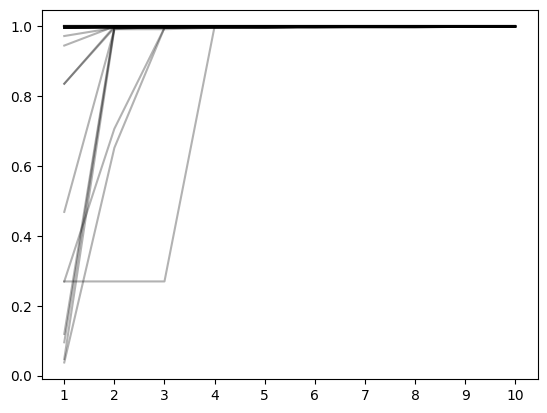

In [ ]:
import matplotlib.pyplot as plt


xrange = np.arange(1,config.n+1)
for i in range(num_trials):
    plt.plot(xrange, trial_max_score_arr[i], alpha=0.3, color='k')
plt.xticks(xrange)
plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


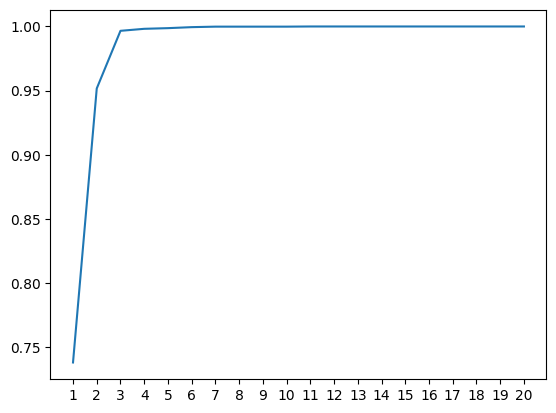

In [ ]:
xrange = np.arange(1,config.n+1)
plt.plot(xrange, trial_max_score_arr)
plt.xticks(xrange)
plt.show()

In [ ]:
config = Config()
config.n = 8
config.agg_strategy = 'last'

num_trials = 30
trial_max_score_arr = np.zeros(config.n)
for trial_id in range(num_trials):
    trial_max_score_arr += _maxk_sequence(input_batch['problem'], config, llm=llm, prm=prm)

trial_max_score_arr /= num_trials

[[1.0, 1.0, 1.0, 1.0, 1.0, 0.376953125, 1.0, 0.98828125]]
[[0.99609375, 0.1484375, 1.0, 1.0, 0.9921875, 1.0, 0.053466796875, 1.0]]
[[0.09521484375, 1.0, 0.07568359375, 0.99609375, 0.99609375, 0.1484375, 0.81640625, 0.96875]]
[[0.99609375, 0.99609375, 1.0, 1.0, 0.62109375, 1.0, 1.0, 1.0]]
[[0.053466796875, 0.99609375, 0.99609375, 0.10693359375, 0.09521484375, 1.0, 0.053466796875, 1.0]]
[[0.98828125, 0.99609375, 1.0, 1.0, 0.984375, 0.408203125, 1.0, 0.3203125]]
[[0.62109375, 0.0849609375, 0.04736328125, 1.0, 0.033203125, 0.99609375, 1.0, 1.0]]
[[0.02294921875, 0.99609375, 0.9921875, 1.0, 0.98828125, 0.99609375, 1.0, 0.99609375]]
[[0.984375, 1.0, 1.0, 0.2451171875, 1.0, 1.0, 0.5, 0.90625]]
[[0.98828125, 0.99609375, 0.9921875, 0.53125, 0.376953125, 1.0, 1.0, 0.07568359375]]
[[1.0, 1.0, 0.99609375, 0.984375, 0.07568359375, 0.9921875, 1.0, 1.0]]
[[0.99609375, 0.99609375, 0.97265625, 1.0, 1.0, 1.0, 0.98828125, 0.99609375]]
[[0.99609375, 0.0849609375, 0.9609375, 0.99609375, 0.26953125, 0.81640

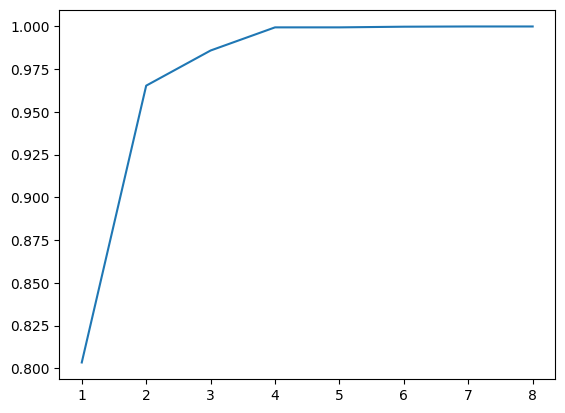

In [ ]:
xrange = np.arange(1,config.n+1)
plt.plot(xrange, trial_max_score_arr)
plt.xticks(xrange)
plt.show()

In [ ]:
question_text = "Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$"
input_batch = {"problem": [question_text]}

In [ ]:
first_step = " ## Step 1: Convert the given rectangular coordinates $(0,3)$ to polar coordinates.\nTo convert from rectangular coordinates to polar coordinates, we use the formulas $r = \\sqrt{x^2 + y^2}$ and $\\theta = \\arctan{\\left(\\frac{y}{x}\\right)}$. Here, $x=0$ and $y=3$.\n\n"
batch_of_prompts = [first_step + question_text]

config = Config()
config.n = 8
config.agg_strategy = 'last'

num_trials = 30
trial_max_score_arr = np.zeros(config.n)
for trial_id in range(num_trials):
    trial_max_score_arr += _maxk_sequence(batch_of_prompts, config, llm=llm, prm=prm)

trial_max_score_arr /= num_trials

[[0.99609375, 0.95703125, 0.9140625, 0.70703125, 0.9921875, 0.796875, 0.99609375, 0.9921875]]
[[0.9921875, 0.99609375, 0.9453125, 0.99609375, 0.9921875, 0.984375, 0.99609375, 0.04736328125]]
[[0.9921875, 0.9765625, 0.94140625, 0.65234375, 1.0, 0.98828125, 0.9609375, 0.99609375]]
[[0.62109375, 0.9921875, 0.9921875, 0.98046875, 0.99609375, 0.953125, 0.9765625, 0.98046875]]
[[0.10693359375, 0.9921875, 0.8671875, 0.98828125, 0.99609375, 0.98828125, 0.99609375, 0.9921875]]
[[0.9921875, 1.0, 0.98828125, 0.9921875, 0.9921875, 0.9921875, 0.2021484375, 0.9921875]]
[[0.98046875, 0.96875, 0.81640625, 0.984375, 0.9921875, 0.9921875, 0.99609375, 0.99609375]]
[[1.0, 0.0849609375, 0.99609375, 0.98046875, 0.73046875, 0.99609375, 0.99609375, 0.99609375]]
[[0.99609375, 0.99609375, 0.98828125, 0.9453125, 0.99609375, 0.349609375, 0.5625, 0.9921875]]
[[0.98828125, 0.9921875, 0.99609375, 0.87890625, 0.9609375, 0.99609375, 0.75390625, 0.9921875]]
[[0.953125, 0.9609375, 0.22265625, 0.53125, 0.9921875, 0.96875

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.67 GiB. GPU 0 has a total capacity of 39.56 GiB of which 2.27 GiB is free. Process 1001707 has 37.27 GiB memory in use. Of the allocated memory 33.64 GiB is allocated by PyTorch, with 23.47 MiB allocated in private pools (e.g., CUDA Graphs), and 3.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)